In [ ]:
!pip install tensorflow==2.5.0

     |████████████████████████████████| 454.3MB 27kB/s 
     |████████████████████████████████| 471kB 38.7MB/s 
     |████████████████████████████████| 6.0MB 28.5MB/s 
     |████████████████████████████████| 4.0MB 23.6MB/s 
  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


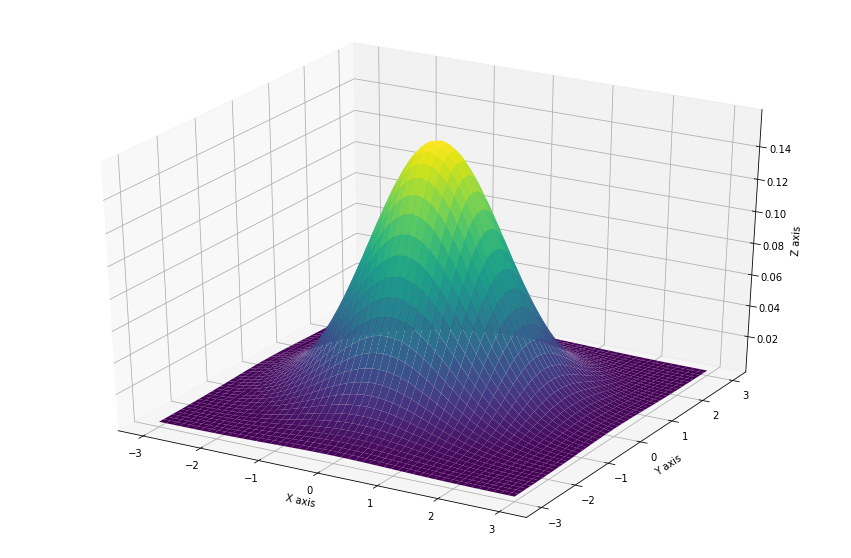

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = 0
variance_x = 1

mu_y = 0
variance_y = 1

#Create grid and multivariate normal
x = np.linspace(-3,3,500)
y = np.linspace(-3,3,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [34]:
rv.rvs(size=10)

array([[-0.32646809, -0.55779133],
       [ 1.27375544, -0.26387084],
       [ 0.36412046, -0.42479491],
       [-0.47102248, -0.98437049],
       [-0.1868691 , -0.81413129],
       [-0.22459003,  0.28248899],
       [ 0.11202416,  1.34877694],
       [-0.23449434, -0.50982277],
       [-0.5729554 , -0.87836046],
       [-0.92781805, -0.71799625]])

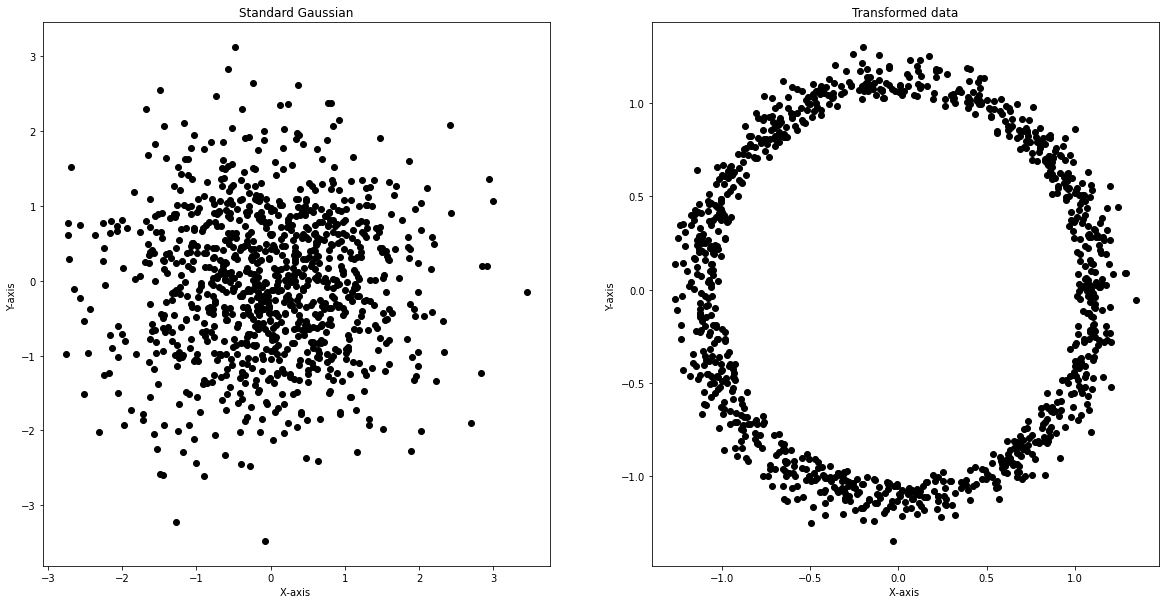

In [40]:
from numpy import linalg as LA
def g(z):
  first_term=z/10
  norm_z=LA.norm(z, axis=1)
  second_term = z / norm_z[:,None]
  return  first_term+second_term

z=rv.rvs(size=1000)
transformed = g(z)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(z[:,0], z[:,1], 'o', color='black')
plt.title("Standard Gaussian")
plt.xlabel('X-axis ')
plt.ylabel('Y-axis ')

plt.subplot(1, 2, 2) # index 2
plt.plot(transformed[:,0], transformed[:,1], 'o', color='black')
plt.title("Transformed data")
plt.xlabel('X-axis ')
plt.ylabel('Y-axis ')

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras import layers

2.5.0
2.5.0


In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
print(x_train.shape[1:])

(784,)


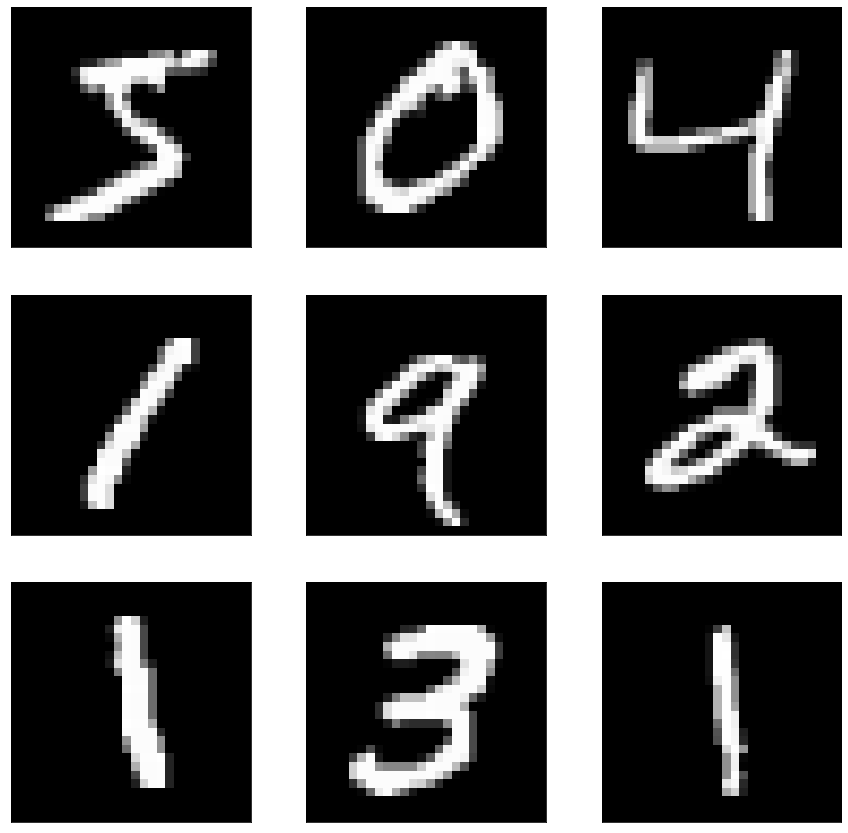

In [ ]:
f, axs = plt.subplots(3,3, figsize=(15,15))
ix=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(x_train[ix].reshape(28,28), cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        ix+=1
plt.show()

# MLP with two hidden layers

In [ ]:
#hyperparameters for the network
n_epoch = 100
n_hidden = 256
z_dim = 10
patience=20
batch_size=100

In [ ]:
#reparameterization trick:
def sampling(args):
    mu, log_var = args
    eps = tf.keras.backend.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + tf.keras.backend.exp(log_var) * eps

#Defining the architecture

#Encoder
x = keras.Input(shape=(x_train.shape[1:]))
x_encoded = layers.Dense(n_hidden, activation='relu')(x)
x_encoded = layers.Dense(n_hidden//2, activation='relu')(x_encoded)
#Latent space
mu = layers.Dense(z_dim)(x_encoded)
log_var = layers.Dense(z_dim)(x_encoded)
z = layers.Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
#Decoder
x_decoder1 = layers.Dense(n_hidden//2, activation='relu')
x_decoder2 = layers.Dense(n_hidden, activation='relu')
x_decoder3 = layers.Dense(x_train.shape[1], activation='sigmoid')

x_decoded = x_decoder1(z)
x_decoded = x_decoder2(x_decoded)
x_hat = x_decoder3(x_decoded)

In [ ]:
#Defining the loss function
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = keras.losses.binary_crossentropy(x, x_hat) * x_train.shape[1]
    kl_loss = 0.5 * tf.keras.backend.sum(tf.keras.backend.square(mu) + tf.keras.backend.exp(log_var) - log_var - 1, axis = -1)
    return reconstruction_loss + kl_loss

In [ ]:
vae = keras.Model(x, x_hat)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 128)          32896       dense_31[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 10)           1290        dense_32[0][0]                   
____________________________________________________________________________________________

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
history = vae.fit(x_train, x_train,
          shuffle=True,
          epochs=n_epoch,
          batch_size=batch_size,
          validation_data=(x_test, x_test), 
          callbacks= [early_stopping], 
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - ETA: 0s - loss: 166.5072

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 9s 143us/sample - loss: 166.5072 - val_loss: 131.2759
Epoch 2/100
60000/60000 [==============================] - 8s 138us/sample - loss: 123.5239 - val_loss: 117.2932
Epoch 3/100
60000/60000 [==============================] - 8s 135us/sample - loss: 113.3952 - val_loss: 109.1025
Epoch 4/100
60000/60000 [==============================] - 8s 139us/sample - loss: 109.0254 - val_loss: 107.0071
Epoch 5/100
60000/60000 [==============================] - 8s 137us/sample - loss: 106.3246 - val_loss: 104.0670
Epoch 6/100
60000/60000 [==============================] - 8s 134us/sample - loss: 104.4575 - val_loss: 103.5553
Epoch 7/100
60000/60000 [==============================] - 8s 138us/sample - loss: 103.0187 - val_loss: 101.9523
Epoch 8/100
60000/60000 [==============================] - 8s 138us/sample - loss: 101.8777 - val_loss: 100.7544
Epoch 9/100
60000/60000 [==============================] - 8s 138us/sample - loss: 100.8978 - val_loss: 100.

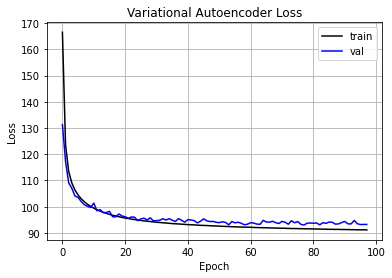

In [ ]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Variational Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Loss')

In [ ]:
x_hat_test = vae.predict(x_test, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


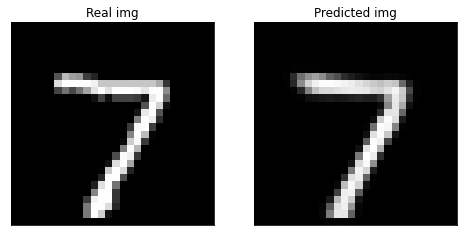

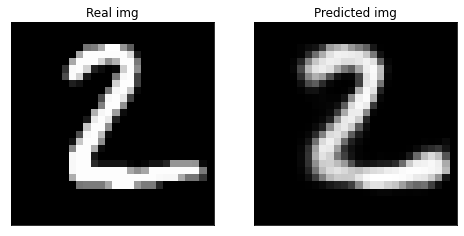

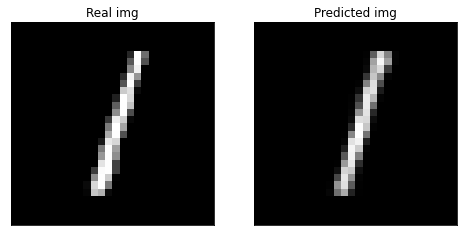

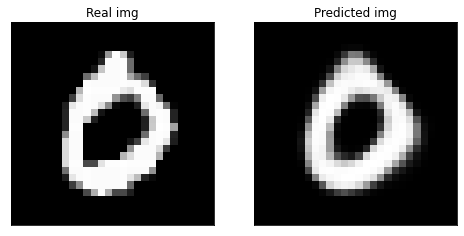

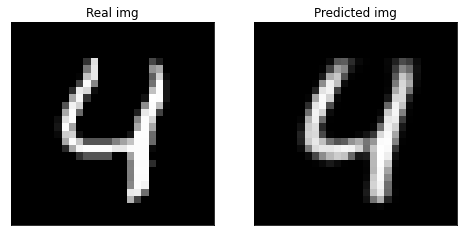

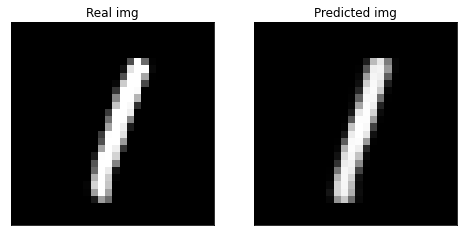

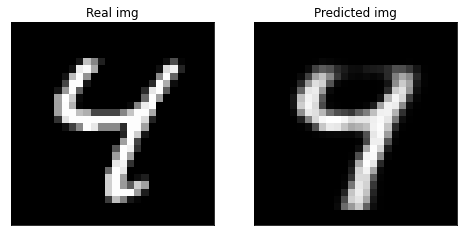

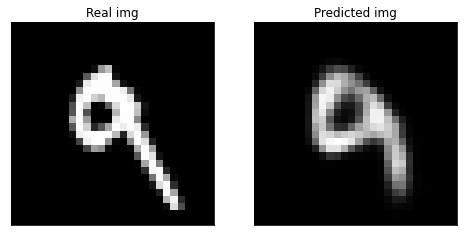

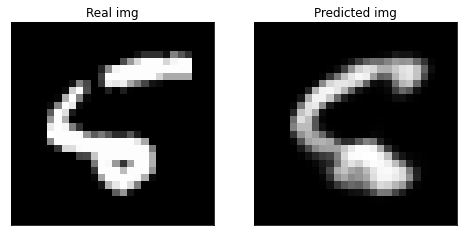

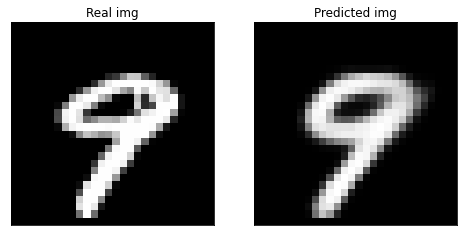

In [ ]:
for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.set_title('Predicted img')
    ax2.imshow(x_hat_test[i].reshape(28,28), cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [ ]:
Encoder = keras.Model(x, z)

z_test = Encoder.predict(x_test, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
#Dimensionality Reduction using t-SNE
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

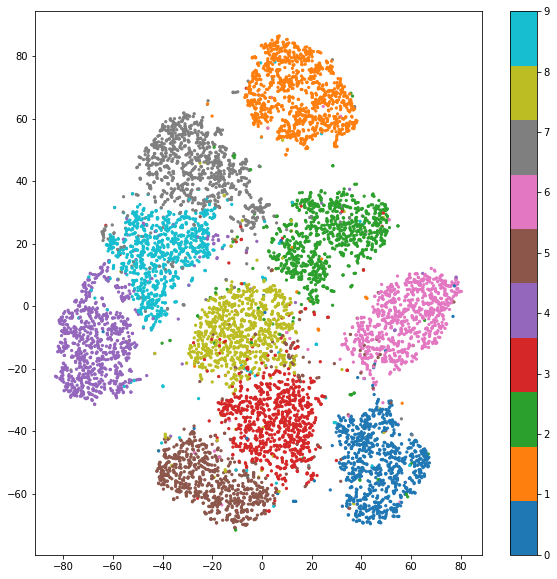

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=20, cmap='tab10', marker='.')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


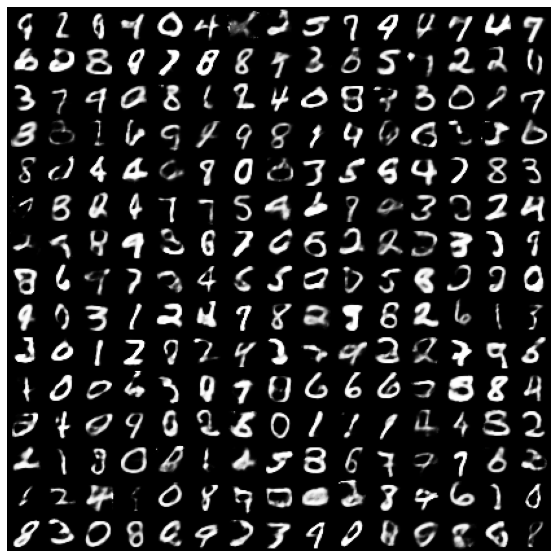

In [ ]:
#Deconding from a normally distributed random variable.
decoder_input = keras.Input(shape=(z_dim,))
decoded1 = x_decoder1(decoder_input)
decoded2 = x_decoder2(decoded1)
decoded3 = x_decoder3(decoded2)
Decoder = keras.Model(decoder_input, decoded3)

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n*n):
    z_sample = np.random.normal(loc=0.0, scale=1.0, size=(1, 10,))
    x_decoded = Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i%n * digit_size: (i%n + 1) * digit_size,
           i//n * digit_size: (i//n + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()

# Deep Convolutional Variational Autoencoder (DCVAE)

In [ ]:
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

In [ ]:
print(x_train.shape)
print(x_train[0,:,:])

(60000, 28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

In [ ]:
import cv2

target_size = (32,32) #For the following architecture, we used 32x32 images.
x_train = np.array([cv2.resize(image, dsize=target_size) for image in x_train])
x_test = np.array([cv2.resize(image, dsize=target_size) for image in x_test])
conv_dim=64
z_dim = 10
batch_size = 100

In [ ]:
print(x_train.shape)

(60000, 32, 32)


In [ ]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)

(60000, 32, 32, 1)


In [ ]:
# As this DCVAE uses more GPU capacity, we have to use generators.

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
generator_train = datagen.flow(x_train, x_train, batch_size=batch_size, shuffle=True)
generator_test = datagen.flow(x_test, x_test, batch_size=batch_size, shuffle=False)

In [ ]:
#Encoder
x = layers.Input(shape=(32,32,1))
x_encoded = layers.Conv2D(conv_dim, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x)
x_encoded = layers.Conv2D(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Conv2D(conv_dim*4, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Conv2D(conv_dim*8, kernel_size=4, strides=(1,1), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Flatten()(x_encoded)
#Latent space
mu = layers.Dense(z_dim)(x_encoded)
log_var = layers.Dense(z_dim)(x_encoded)
z = layers.Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
#Decoder
x_decoder1 = layers.Dense(4 * 4 * 512)
x_decoder2 = layers.Reshape((4, 4, 512))
x_decoder3 = layers.Conv2DTranspose(conv_dim*8, kernel_size=1, strides=(1,1), padding='same', activation='relu')
x_decoder4 = layers.Conv2DTranspose(conv_dim*4, kernel_size=1, strides=(1,1), padding='same', activation='relu')
x_decoder5 = layers.Conv2DTranspose(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')
x_decoder6 = layers.Conv2DTranspose(conv_dim*1, kernel_size=4, strides=(2,2), padding='same', activation='relu')
x_rec = layers.Conv2DTranspose(1, kernel_size=4, strides=(2,2), padding='same', activation='sigmoid')

x_decoded = x_decoder1(z)
x_decoded = x_decoder2(x_decoded)
x_decoded = x_decoder3(x_decoded)
x_decoded = x_decoder4(x_decoded)
x_decoded = x_decoder5(x_decoded)
x_decoded = x_decoder6(x_decoded)
x_hat = x_rec(x_decoded)

In [ ]:
#Defining the loss function
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat)) * x_train.shape[1]
    kl_loss = 0.5 * tf.keras.backend.sum(tf.keras.backend.square(mu) + tf.keras.backend.exp(log_var) - log_var - 1, axis = -1)
    return reconstruction_loss + kl_loss

In [ ]:
patience=10
dcvae = keras.Model(x, x_hat)
dcvae.compile(optimizer='rmsprop', loss=vae_loss)
dcvae.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   1088        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 8, 128)    131200      conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 4, 4, 256)    524544      conv2d_9[0][0]                   
____________________________________________________________________________________________

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
n_epoch=20
history = dcvae.fit_generator(generator_train,
          shuffle=True,
          epochs=n_epoch,
          validation_data=generator_test, 
          callbacks= [early_stopping],
          steps_per_epoch=x_train.shape[0]//batch_size,
          validation_steps=x_test.shape[0]//batch_size,
          verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20
141/600 [======>.......................] - ETA: 12:21 - batch: 70.0000 - size: 100.0000 - loss: 9.4562

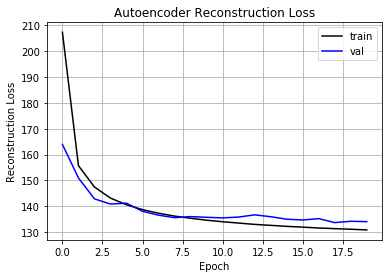

In [ ]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

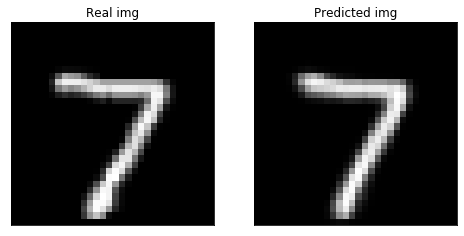

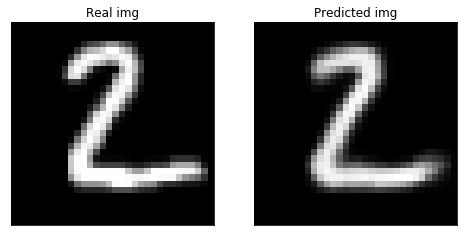

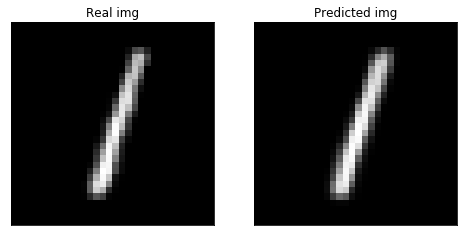

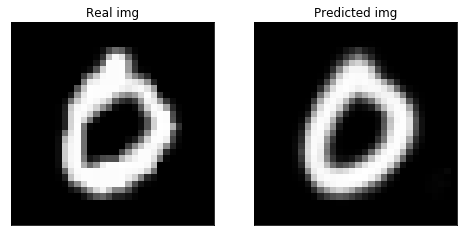

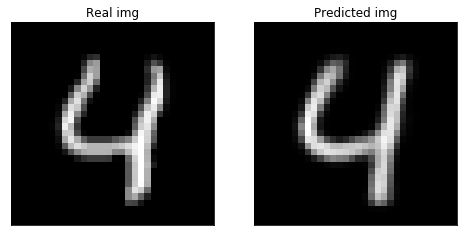

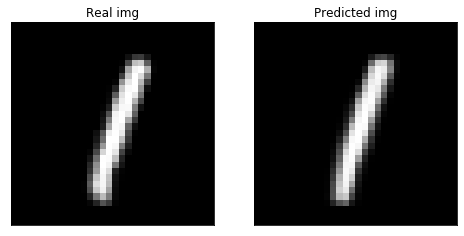

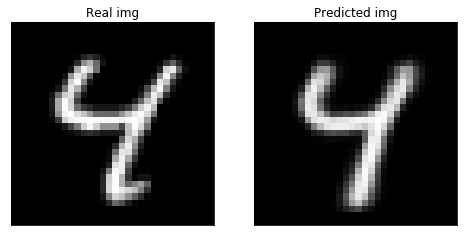

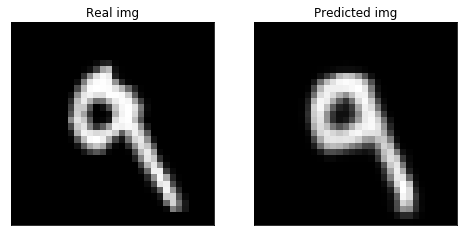

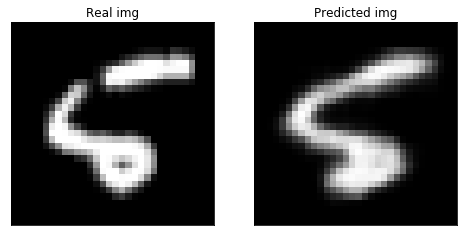

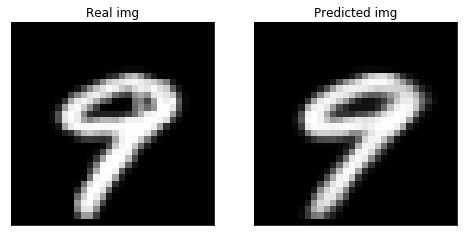

In [ ]:
x_hat_test = dcvae.predict(x_test, batch_size=batch_size)

for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i, :, :, 0], cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.set_title('Predicted img')
    ax2.imshow(x_hat_test[i, :, :, 0], cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [ ]:
Encoder = keras.Model(x, z)

z_test = Encoder.predict(x_test, batch_size=batch_size)
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

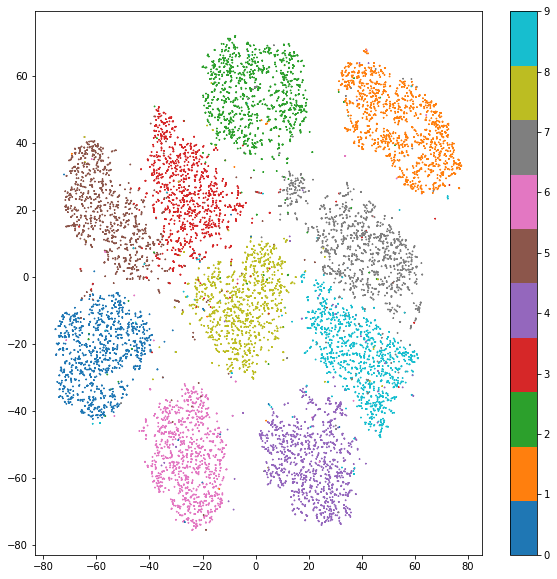

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()

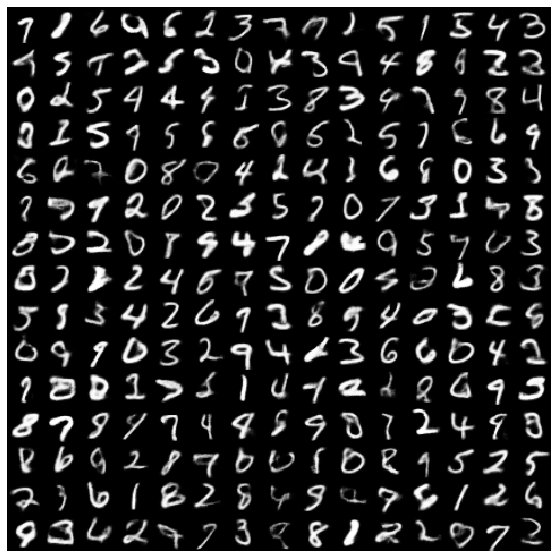

In [ ]:
decoder_input = layers.Input(shape=(z_dim,))
decoded1 = x_decoder1(decoder_input)
decoded2 = x_decoder2(decoded1)
decoded3 = x_decoder3(decoded2)
decoded4 = x_decoder4(decoded3)
decoded5 = x_decoder5(decoded4)
decoded6 = x_decoder6(decoded5)
x_hat = x_rec(decoded6)
Decoder = keras.Model(decoder_input, x_hat)

n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n*n):
    z_sample = np.random.normal(loc=0.0, scale=1.0, size=(1, 10,))
    x_decoded = Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i%n * digit_size: (i%n + 1) * digit_size,
           i//n * digit_size: (i//n + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()